In [44]:
from pathlib import Path
import pandas as pd 
import numpy as np
%matplotlib widget 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

# Local modules
from old_code import time_difference
from old_code import well_corrections
from old_code import closure_analysis
from old_code import plotting

import re

# ----------------------------
# File paths (cross-platform)
# ----------------------------
base = Path("Data") 

SURF_PATH = base / "XLOT_minifrac/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 2 - Vlieland Claystone_Cementing Unit_Data.txt"
DOWN_PATH = base / "XLOT_minifrac/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 2 - Vlieland Claystone_Downhole Gauge_Data.TXT"

CAP_S = 210                     # analyze/plot max 3.5 minutes

USE_MANUAL_SHUTIN = True        # automatically detect shut-in based on pumping rate


# ----------------------------
# Depths & lag estimation
# ----------------------------
# Example MD/TVD arrays; replace with real values
MD = np.array([900.2, 910, 919.6], dtype=float)
TVD = np.array([900.18, np.nan, 919.58], dtype=float)  # NaN = missing value
TVD_fracture_m = 1323.25
gauge_index    = 1  # index of the downhole gauge in the MD/TVD arrays

# Surface gauge is x m ABOVE TVD=0  → TVD_surface_sensor_m = -x (down is +)
TVD_surface_sensor_m = -1.48
delta_tvd_surface_to_frac = TVD_fracture_m - TVD_surface_sensor_m  # = TVD_fracture_m + 1.46

# NOTE: we use the (MD, TVD, gauge_index, TVD_fracture_m) signature per the fixed helper
TVD_interp, TVD_gauge_m, delta_tvd_m = well_corrections.estimate_lag(MD, TVD, gauge_index, TVD_fracture_m)

def to_num(series):
    """
    Normalize numeric text: strip whitespace, remove NBSPs, comma→dot, coerce to float.
    Returns a pandas Series[float].
    """
    s = pd.Series(series, copy=False)
    if s.dtype.kind in "biufc":
        return pd.to_numeric(s, errors="coerce")
    s = s.astype(str).str.strip()
    s = s.str.replace('\u00A0', '', regex=False)   # NBSP
    s = s.str.replace(',', '.', regex=False)       # decimal comma -> dot
    s = s.replace({'': None})
    return pd.to_numeric(s, errors='coerce')

def _safe_name(s: str) -> str:
    """Make a safe Python variable name from a column header."""
    s = str(s).strip()
    s = re.sub(r"\s+", "_", s)            # spaces -> _
    s = re.sub(r"[^0-9a-zA-Z_]", "", s)   # remove other weird chars
    if re.match(r"^\d", s):               # leading digit -> prefix with _
        s = "_" + s
    return s

def _looks_like_time(colname: str) -> bool:
    cn = colname.lower()
    return ("time" in cn) or ("date" in cn) or ("datetime" in cn)

def make_vars_from_df(df, prefix: str):
    """
    Create variables in the global namespace from df columns.
    - Names are prefixed (e.g., 'S_' or 'D_') and sanitized.
    - Numeric columns go through to_num(); time-ish columns are left as-is.
    - Handles duplicate column names by adding _2, _3, ...
    """
    seen = {}
    for col in df.columns:
        base = prefix + _safe_name(col)
        name = base
        k = 2
        while name in globals():
            name = f"{base}_{k}"
            k += 1

        series = df[col]
        if not _looks_like_time(col):
            series = to_num(series)  # your helper

        globals()[name] = series
        seen[col] = name
    return seen  # mapping original header -> created var name

def get_or_nan(df, col):
    """Return numeric series for existing column or a NaN series matching df length."""
    if col in df.columns:
        return to_num(df[col])
    return pd.Series([np.nan] * len(df), index=df.index, dtype=float)

# (your code above)
dfS = pd.read_csv(SURF_PATH, sep="\t", engine="python", on_bad_lines="skip")
dfD = pd.read_csv(DOWN_PATH, sep="\t", engine="python", on_bad_lines="skip")

print("Surface data file loaded:", SURF_PATH.resolve())
print("Downhole data file loaded:", DOWN_PATH.resolve())

dfD.columns = ['None', 'Time', 'Delta Time', 'Pressure', 'Temperature', 'None2']
dfS = dfS.iloc[1:].reset_index(drop=True)
dfD = dfD.iloc[4:, :-2].reset_index(drop=True)

# Create variables straight from headers
mapS = make_vars_from_df(dfS, prefix="S_")
mapD = make_vars_from_df(dfD, prefix="D_")

print(dfS.columns)
print(dfD['Time'])


Surface data file loaded: /Users/william/Desktop/Thesis-AES/Data/XLOT_minifrac/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 2 - Vlieland Claystone_Cementing Unit_Data.txt
Downhole data file loaded: /Users/william/Desktop/Thesis-AES/Data/XLOT_minifrac/Amstelland/NLOG_GS_PUB_AMS-01_XLOT 2 - Vlieland Claystone_Downhole Gauge_Data.TXT
Index(['Time', 'Treating Pressure', 'Flow Rate', 'Density', 'Volume',
       'CMT Return Press', 'CMT Return Rate', 'CMT Return Dens',
       'Return Volume'],
      dtype='object')
0         12-12-2023 01:20:15
1         12-12-2023 01:20:18
2         12-12-2023 01:20:21
3         12-12-2023 01:20:24
4         12-12-2023 01:20:27
                 ...         
27258     13-12-2023 00:03:09
27259     13-12-2023 00:03:12
27260     13-12-2023 00:03:15
27261     13-12-2023 00:03:18
27262     13-12-2023 00:03:21
Name: Time, Length: 27263, dtype: object


In [55]:
# Surface time format: %m:%d:%Y:%H:%M:%S
time_surface = pd.to_datetime(dfS['Time'], format='%m:%d:%Y:%H:%M:%S', errors='coerce')

# Downhole time format: %d-%m-%Y %H:%M:%S
time_downhole = pd.to_datetime(dfD['Time'].astype(str).str.strip(),
                               format='%d-%m-%Y %H:%M:%S', errors='coerce')

print(time_surface)



0       2023-12-12 13:58:45
1       2023-12-12 13:58:46
2       2023-12-12 13:58:47
3       2023-12-12 13:58:48
4       2023-12-12 13:58:49
                ...        
10349   2023-12-12 17:10:35
10350   2023-12-12 17:10:36
10351   2023-12-12 17:10:37
10352   2023-12-12 17:10:38
10353   2023-12-12 17:10:39
Name: Time, Length: 10354, dtype: datetime64[ns]


In [52]:
# ----------------------------
# Time windows
# ----------------------------
startS = pd.to_datetime("2023-12-12 14:53:00")
endS   = pd.to_datetime("2023-12-12 17:10:00")

startD = pd.to_datetime("2023-12-12 14:53:00")
endD   = pd.to_datetime("2023-12-12 17:10:00")

In [57]:
# Surface time format: %m:%d:%Y:%H:%M:%S
time_surface = pd.to_datetime(dfS['Time'], format='%m:%d:%Y:%H:%M:%S', errors='coerce')

# Downhole time format: %d-%m-%Y %H:%M:%S
time_downhole = pd.to_datetime(dfD['Time'].astype(str).str.strip(),
                               format='%d-%m-%Y %H:%M:%S', errors='coerce')

# --- Surface data ---
pressure_S        = get_or_nan(dfS, 'Treating Pressure')
flowrate_S        = get_or_nan(dfS, 'Flow Rate')
density_S         = get_or_nan(dfS, 'Density')
volume_S          = get_or_nan(dfS, 'Volume')
return_volume_S   = get_or_nan(dfS, 'Return Volume')
return_rate_S     = get_or_nan(dfS, 'CMT Return Press')
return_pressure_S = get_or_nan(dfS, 'CMT Return Press')
return_density_S  = get_or_nan(dfS, 'CMT Return Dens')

# --- Downhole data ---
delta_time_D  = get_or_nan(dfD, 'Delta Time')
pressure_D    = get_or_nan(dfD, 'Pressure')
temperature_D = get_or_nan(dfD, 'Temperature')

# remove for strings:

pressure_S = pd.to_numeric(pressure_S, errors='coerce')

print(time_downhole)
print(pressure_S)
print(flowrate_S)

0       2023-12-12 01:20:15
1       2023-12-12 01:20:18
2       2023-12-12 01:20:21
3       2023-12-12 01:20:24
4       2023-12-12 01:20:27
                ...        
27258   2023-12-13 00:03:09
27259   2023-12-13 00:03:12
27260   2023-12-13 00:03:15
27261   2023-12-13 00:03:18
27262   2023-12-13 00:03:21
Name: Time, Length: 27263, dtype: datetime64[ns]
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
10349    1.0
10350    1.0
10351    1.0
10352    1.0
10353    1.0
Name: Treating Pressure, Length: 10354, dtype: float64
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
10349    0.0
10350    0.0
10351    0.0
10352    0.0
10353    0.0
Name: Flow Rate, Length: 10354, dtype: float64


surface time min/max: (Timestamp('2023-12-12 13:58:45'), Timestamp('2023-12-12 17:10:39'))
downhole time min/max: (Timestamp('2023-12-12 01:20:15'), Timestamp('2023-12-13 00:03:21'))
shut-in times:  159    2023-12-12 14:18:15
311    2023-12-12 14:20:49
507    2023-12-12 14:24:08
618    2023-12-12 14:26:00
624    2023-12-12 14:26:06
920    2023-12-12 14:31:06
927    2023-12-12 14:31:13
2142   2023-12-12 14:51:45
2348   2023-12-12 14:55:14
2725   2023-12-12 15:01:37
4343   2023-12-12 15:29:00
5312   2023-12-12 15:45:23
5508   2023-12-12 15:48:42
6620   2023-12-12 16:07:31
6928   2023-12-12 16:12:44
7314   2023-12-12 16:19:16
7490   2023-12-12 16:22:14
8220   2023-12-12 16:34:36
Name: Time, dtype: datetime64[ns]
Estimated delay: 0.9275 h


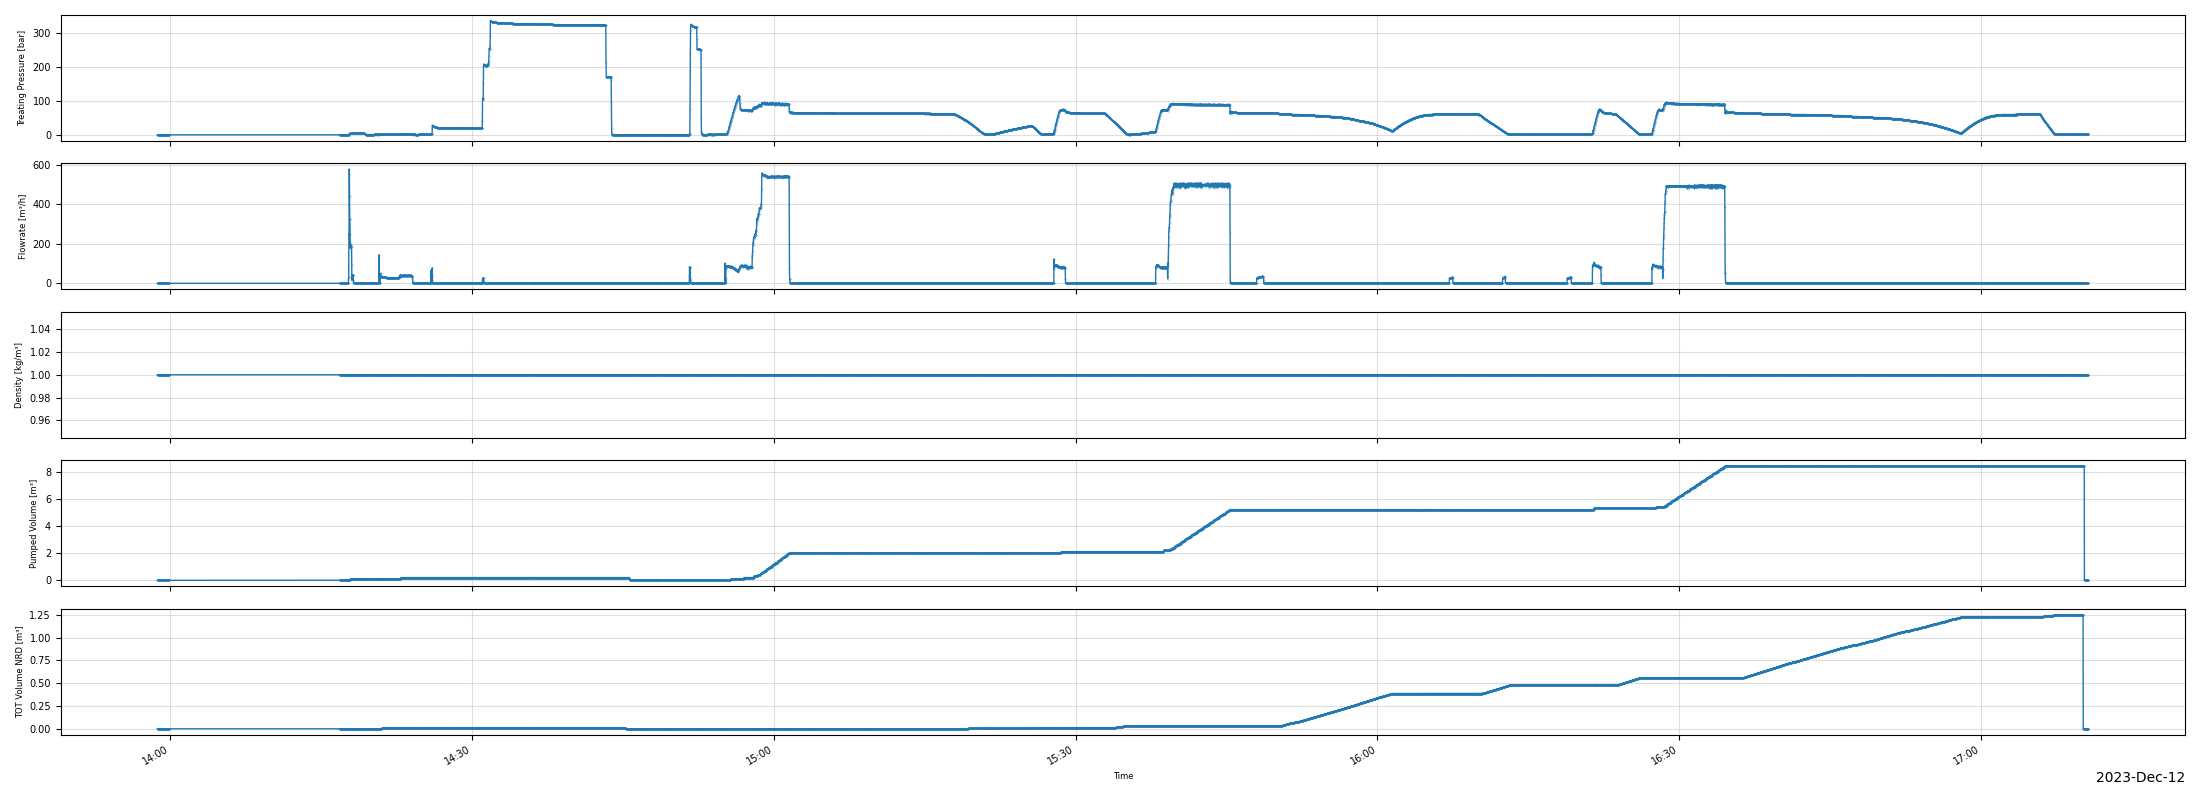

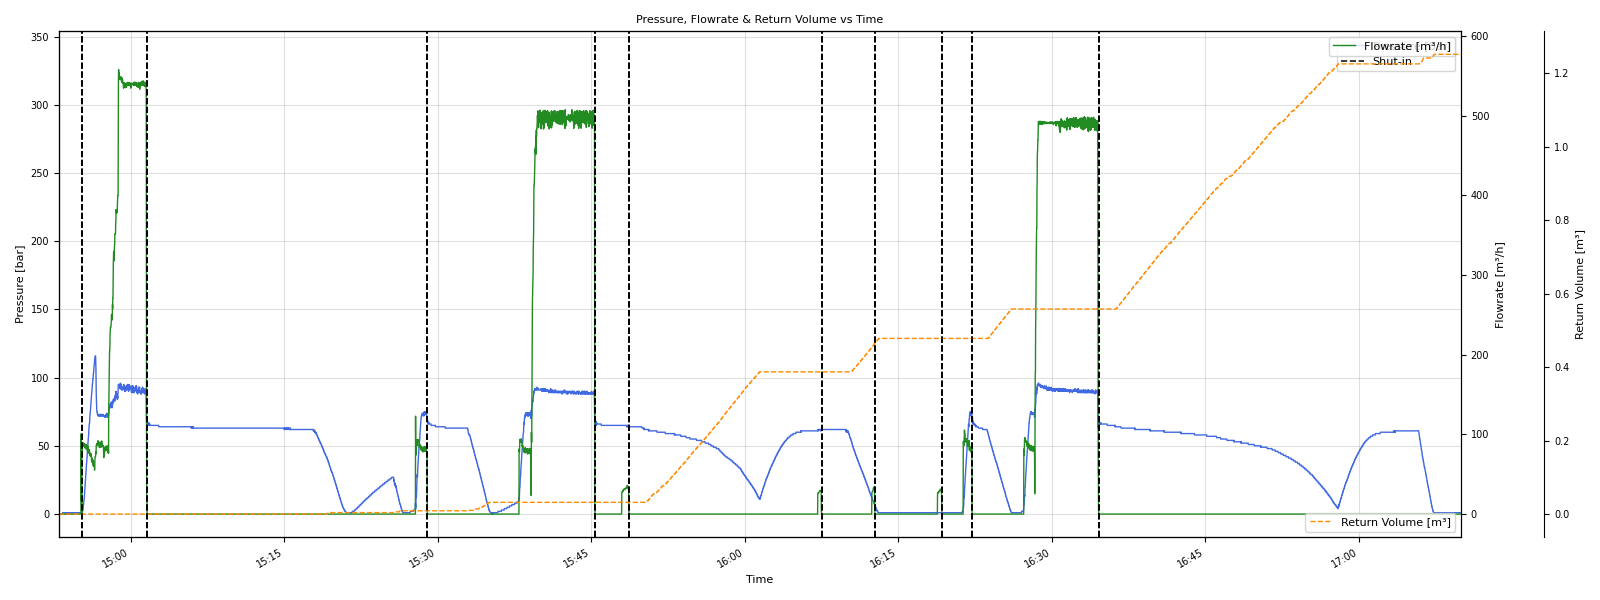

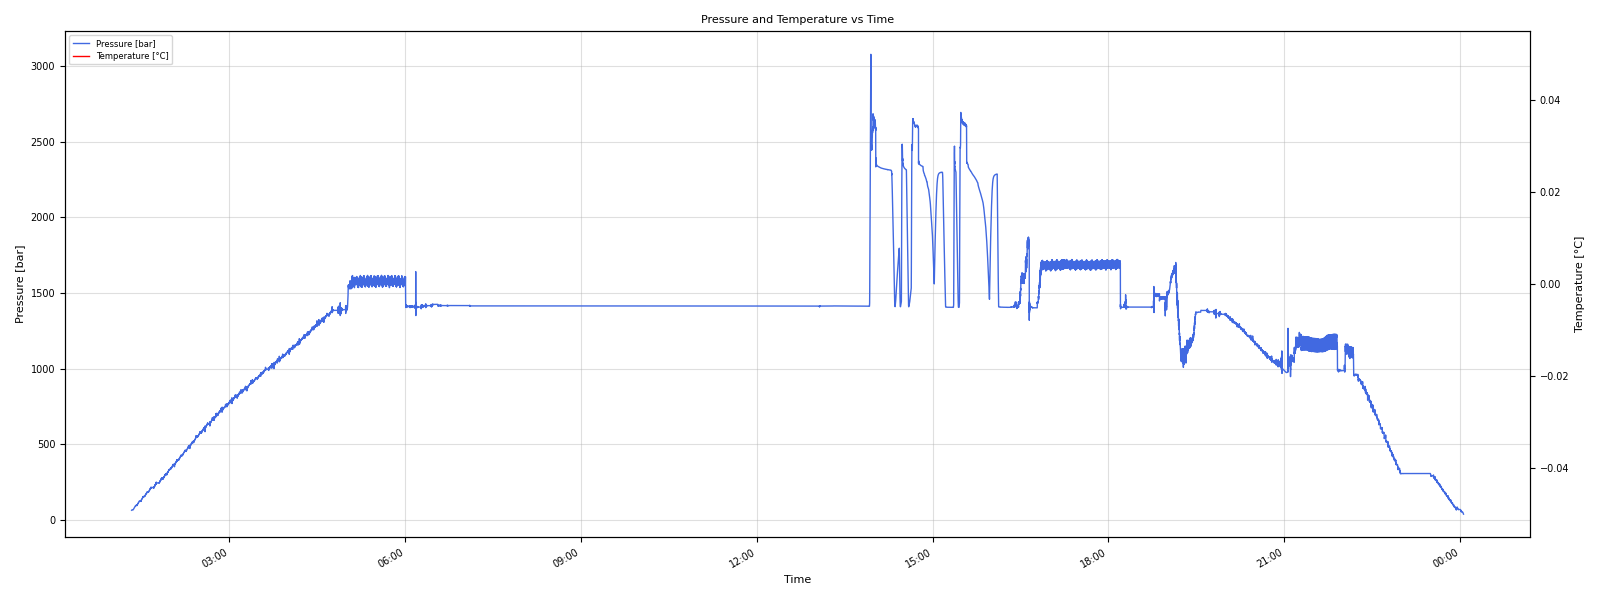

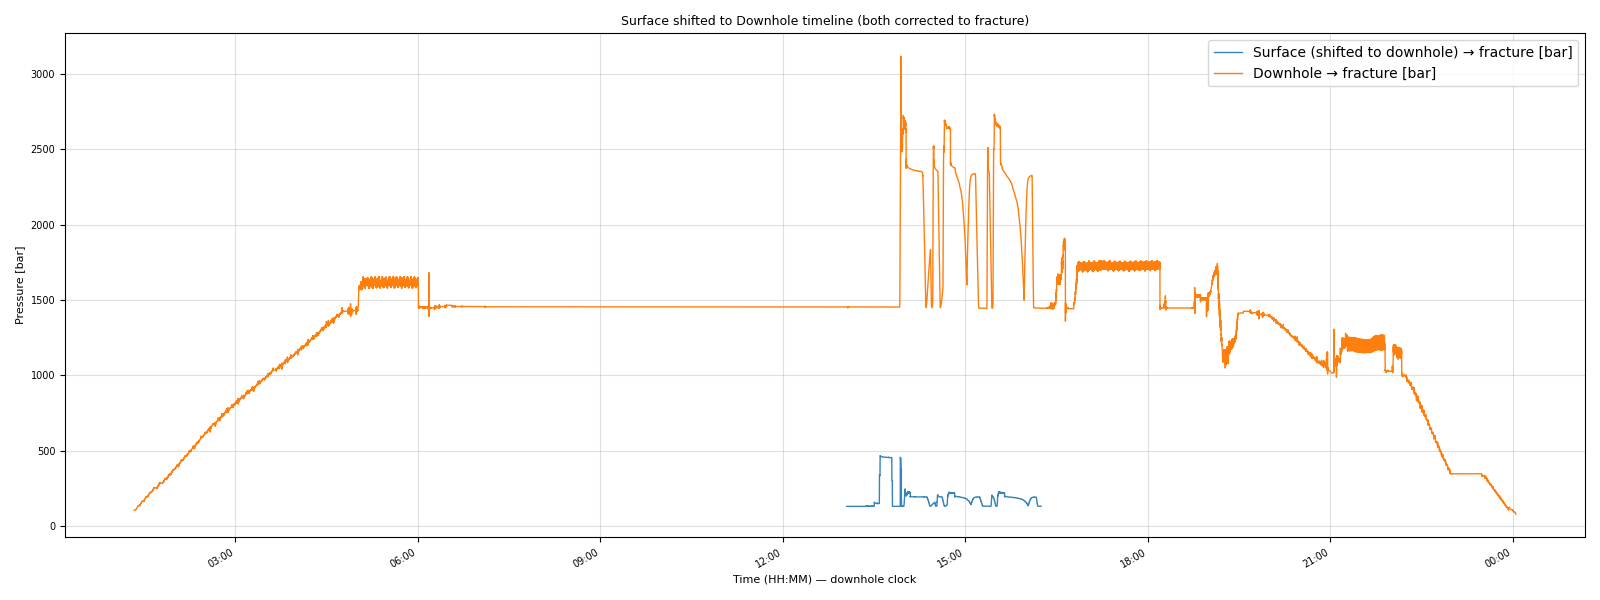

In [59]:

# ----------------------------
# Masks (NaN-safe)
# ----------------------------
maskS = (
    pressure_S.notna() &
    time_surface.notna()
)

time_S               = time_surface[maskS]
pressure_S           = pressure_S[maskS]
flowrate_S           = flowrate_S[maskS]
density_S            = density_S[maskS]
volume_S             = volume_S[maskS]
return_volume_S      = return_volume_S[maskS]

print('surface time min/max:', (time_surface.min(), time_surface.max()))

maskD = (
    time_downhole.notna() &
    pressure_D.notna() 
)

time_D        = time_downhole[maskD]
delta_time_D  = delta_time_D[maskD]
pressure_D    = pressure_D[maskD]
temperature_D = temperature_D[maskD]

print('downhole time min/max:', (time_downhole.min(), time_downhole.max()))

# ----------------------------
# Surface panels
# ----------------------------

fig1, axs1 = plotting.plot_surface_panels(
    time_S, pressure_S, flowrate_S, density_S, volume_S, return_volume_S,
    figsize=(22, 8), markersize=0.2, linewidth=1.0, tick_labelsize=7, title_labelsize=6
)

# ----------------------------
# Triple-axis (surface subset)
# ----------------------------
fig2, (ax1, ax2, ax3) = plotting.plot_triple_axis(
    time_S, pressure_S, flowrate_S, return_volume_S,
    start=startS, end=endS, figsize=(16, 6)
)

# --- Simple shut-in lines on Figure 2 (plot_triple_axis) ---

q_thresh = 0.2  # m³/h threshold for "pumping" vs "shut-in"

is_pumping = (flowrate_S.fillna(0.0) > q_thresh)
shut_in_mask = is_pumping.shift(1, fill_value=False) & (~is_pumping)
shut_in_times = pd.to_datetime(time_S[shut_in_mask])
print('shut-in times: ', shut_in_times)

for ts in shut_in_times:
    for ax in (ax1, ax2, ax3):
        ax.axvline(ts, color="k", linestyle="--", linewidth=1.2, alpha=0.9)

# Add legend entry (optional)
if len(shut_in_times) > 0:
    ax1.axvline(shut_in_times.iloc[0], color="k", linestyle="--", linewidth=1.2, alpha=0.9, label="Shut-in")
    for ax in (ax1, ax2, ax3):
        h, l = ax.get_legend_handles_labels()
        if l:
            ax.legend(h, l, loc="best", fontsize=8)


# ----------------------------
# Downhole P/T plot
# ----------------------------
fig3, (ax4, ax5) = plotting.plot_downhole_pt(time_D, pressure_D, temperature_D, figsize=(16, 6))


# Estimate delay (surface vs downhole)
try:
    lag_s, grid_step = time_difference.estimate_delay_seconds_robust(
        time_S, pressure_S,
        time_D, pressure_D,
        max_lag_s=4*3600,    # 4 hours
        detrend_window_s=120
    )
except Exception as e:
    print("Delay estimation failed; defaulting lag_s=0. Reason:", e)
    lag_s = 0.0
print(f"Estimated delay: {float(lag_s)/3600} h")
# To align SURFACE to DOWNHOLE we shift SURFACE by **-lag_s**.

# ----------------------------
# Hydrostatic corrections to fracture depth
# ----------------------------
# Surface pressure corrected to fracture (if surface sensor is at TVD≈0, ΔTVD≈TVD_fracture_m)
p_surface_corr, _ = well_corrections.hydrostatic_correct_to_fracture(
    p_gauge=pressure_S,      # SURFACE treating pressure [bar]
    time_gauge=time_S,
    rho_surface=density_S,   # surface density series
    time_surface=time_S,
    delta_tvd_m=delta_tvd_surface_to_frac,  # surface(0) -> fracture
    out_units='bar',
    lag_s=None
)

# Downhole gauge corrected to fracture
p_downhole_corr, _ = well_corrections.hydrostatic_correct_to_fracture(
    p_gauge=pressure_D,      # DOWNHOLE gauge [bar]
    time_gauge=time_D,
    rho_surface=density_S,   # use surface density aligned to DH via lag_s
    time_surface=time_S,
    delta_tvd_m=delta_tvd_m, # TVD_fracture - TVD_gauge
    out_units='bar',
    lag_s=lag_s
)

# ----------------------------
# Build aligned timelines (DOWNHOLE clock)
# ----------------------------
surface_dt_orig  = pd.to_datetime(time_S)
downhole_dt_orig = pd.to_datetime(time_D)

# Shift SURFACE timestamps by **-lag_s** to align onto DOWNHOLE clock
surface_dt_aligned_to_dh = surface_dt_orig - pd.to_timedelta(float(lag_s), unit='s')

y_surface  = pd.Series(p_surface_corr, copy=False).astype(float).to_numpy()
y_downhole = pd.Series(p_downhole_corr, copy=False).astype(float).to_numpy()

# Plot alignment (datetime)
figA, axA = plotting.plot_alignment(surface_dt_aligned_to_dh, y_surface, downhole_dt_orig, y_downhole, figsize=(16, 6))
